In [80]:
import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np
import re
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.options.display.max_colwidth = 1000
%matplotlib inline

In [81]:
# Functions
def get_unique_value_col(table, string=False):
    '''
    table: pandas dataframe
    string: computes unique value only for columns containing string
    ''' 
    unique_value = []
    unique_value_str = set()
    for col in table.columns:
        unique_value.append(list(pd.unique(table[col])))
        if string and col != 'patient id':
            unique_value_str.update(set(pd.unique(table[col])))
    
    if string: 
        #even when the column dtype is str, some values are not string
        unique_value_str_clean = unique_value_str.copy()
        for el in unique_value_str:
            if not(isinstance(el, str)):
                unique_value_str_clean.remove(el)
        return(unique_value_str_clean)
    
    return pd.DataFrame({"unique_value": unique_value}, index=table.columns)     


def check_merging(table1, table2, merged, columns_merged):  
    for col in columns_merged:
        NA_table1 = table1[col].isna().sum()
        NA_table2 = table2[col].isna().sum()
        NA_merged = merged[col].isna().sum()
        if not(np.equal((NA_table1 + NA_table2),NA_merged)):
            return print(f"error in {col}")
    if not((table1.shape[0]+table2.shape[0]) == merged.shape[0]):
        return print(f'error in na counts')
    return print('ok')

def get_plot_na(table, axis):
    na_count = table.isna().sum(axis=axis).sort_values(ascending=False)
    if axis==0:
        labels={'index': 'features', 'value':'missing value count'}
        fig = px.bar(na_count, height=600, width=2000, labels=labels)

    else:
        labels={'index': 'number of missing value', 'value':'number of patients'}
        fig = px.bar(na_count.value_counts().sort_index(), height=600, width=2000, labels=labels)

    fig.update_layout(font_size=8, bargap=0.3)
    return fig

YES_REPLACEMENT = 'yes'
NO_REPLACEMENT = 'no'

# Loading

In [82]:
filepath_stroke = "../data_cleaning/clean_data/stroke_clean_v1.csv"
filepath_perfusion = '../data_cleaning/clean_data/perfusion_clean_v1.csv'
filepath_desc = '../data_cleaning/clean_data/description.csv'
df_perfusion = pd.read_csv(filepath_perfusion, header=0)
df_stroke = pd.read_csv(filepath_stroke)
df_desc = pd.read_csv(filepath_desc, usecols=range(5))

In [83]:
df_stroke.head()

,patient id,completed visit status,htn patient medical history,group,age,height/m,mass/kg,bmi,gender,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,dm patient medical history,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
0,s0011,ineligible,yes,control,70,1.6383,71.667594,26.701519,f,yes,no,20.0,40.0,yes,0.0,no,no,no,no,no,no,0.0,1.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no
1,s0033,excluded,no,control,65,1.8200,92.986000,28.072093,m,yes,no,10.0,10.0,yes,1.0,no,no,no,no,no,no,0.0,2.0,1.0,1.0,1.0,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no
2,s0044,completed,no,control,74,1.7018,68.038855,23.493080,f,yes,NaN,40.0,40.0,yes,2.0,no,yes,yes,no,no,yes,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
3,s0067,completed,no,control,70,1.6764,68.492448,24.371788,m,no,no,0.0,0.0,yes,7.0,no,no,no,no,no,no,1.0,0.0,0.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
4,s0068,completed,no,control,79,1.5748,64.863709,26.154774,f,no,no,0.0,0.0,no,0.0,no,no,no,no,no,no,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


In [84]:
df_perfusion.head()

,patient id,study,diabetes duration,age,sex,height (m),mass (kg),bmi,diabetes,previous tobacco use,current tobacco use,packyears,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,stroke patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
0,s0250,ge75,7.0,50,male,1.790,114.65,35.782279,dm,yes,no,2.86,10.0,yes,7.0,no,no,no,no,no,no,1.0,1.0,1.0,1.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes
1,s0254,ge75,0.0,69,female,1.531,56.90,24.275148,nondm,yes,no,0.14,1.0,yes,0.5,no,no,no,no,yes,no,1.0,1.0,1.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
2,s0255,ge75,3.0,78,female,1.520,65.77,28.466932,dm,no,no,0.00,0.0,yes,9.0,no,no,no,no,no,no,0.0,3.0,0.0,3.0,0.0,no,no,no,no,yes,no,no,no,no,yes,no,no,no,yes,no,no,no,no
3,s0256,ge75,23.0,65,female,1.575,73.50,29.629630,dm,yes,no,5.71,20.0,yes,3.0,no,no,no,no,NaN,no,2.0,1.0,0.0,3.0,1.0,yes,no,no,no,yes,yes,no,no,no,yes,no,no,no,no,no,no,no,yes
4,s0257,ge75,0.0,55,male,1.700,70.31,24.328720,nondm,no,no,0.00,0.0,no,0.0,no,no,no,no,no,no,0.0,1.0,1.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


In [85]:
df_desc.head()

,patient id,s0328,s0342,variable description,units
0,NaN,NaN,NaN,NaN,NaN
1,study,ge75,ge75,study number,NaN
2,completed visits status,completed,completed,completed study status,NaN
3,htn patient medical history,no,no,hypertension patient history,NaN
4,group 2,control,dm,group control diabetes,NaN


# Introduction

This jupyter notebook aims to: 
- finalize the data cleaning to find the common features between the stroke and the perfusion datasets
- features relevance for SmartCompanion development
- find protective and risk features through modelling and clustering

The stroke study excludes diabetic patients and the perfusion one excludes people who had a severe stroke. 

To do so we will create a model of stroke prediction based on the stroke dataset and will apply it to the perfusion dataset. Prediction results will be analyze with the clustering results

Problems: 
- check if there's no common patient between the two datasets
- exclude TIA patients
- what to do with illegible patients (having diabetes in the stroke study and a severe stroke in the perfusion one)
- Optimal number of features, features correlations, etc.
- how to deal with mixed data

# Check consistency between the two datasets

In [86]:
df_stroke.shape

(143, 44)

In [87]:
df_perfusion.shape

(87, 44)

In [88]:
common_col = set(df_perfusion.columns) & set(df_stroke.columns)


Let's check if there are common patients between the datasets

In [89]:
set_perfusion = set(df_perfusion["patient id"])
set_stroke = set(df_stroke["patient id"])
# Common patients
print(f'common patient between perfusion and stroke {len(set_perfusion & set_stroke)}')

common patient between perfusion and stroke 0


In [90]:
common_col = set(df_perfusion.columns) & set(df_stroke.columns)
print(len(common_col))
list(common_col)

36


['previous tobacco use',
 'current tobacco use',
 'oh autonomic symptoms',
 'antiplatelets',
 'oral hypoglycemic',
 'alcohol dose/week',
 'atrial fibtrillation patient medical history',
 'statins',
 'strokefamily history',
 'heart failure =chf /ifarction=mi patient medical history',
 'ca ++ blockers',
 'patient id',
 'beta blockers',
 'previous alcohol use',
 'neuropathy autonomic symptoms',
 'htn family history',
 'painful feet autonomic symptoms',
 'anticoagulants',
 'years',
 'syncope autonomic symptoms',
 'cancer# family history',
 'dm family history',
 'cancer patient medical history',
 'ace inhibitors',
 'bmi',
 'antihyperlipidemic',
 'heartdisease family history',
 'estrogen',
 'arbs',
 'hyperlipidemia patient medical history',
 'age',
 'antiparkinsonian',
 'diuretics',
 'numbness autonomic symptoms',
 'insulin(yes or no)',
 'dizziness autonomic symptoms']

36 common features over 44 including demographic, lifestyle and medicall record features

In [91]:
undetected_stroke = df_stroke.columns[~df_stroke.columns.isin(df_perfusion.columns)]
list(undetected_stroke)

['completed visit status',
 'htn patient medical history',
 'group',
 'height/m',
 'mass/kg',
 'gender',
 'pack years',
 'dm patient medical history']

In [92]:
get_unique_value_col(df_stroke[undetected_stroke])

,unique_value
completed visit status,"[ineligible, excluded, completed, v1, lost to followup, excluded pending pcp]"
htn patient medical history,"[yes, no, nan]"
group,"[control, stroke]"
height/m,"[1.6383, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.6256, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.715, 1.72, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.64, 1.67, 1.65, 1.59, 1.78, 1.55, 1.47, 1.56, 1.74, nan, 1.83, 1.62, 1.81, 1.53]"
mass/kg,"[71.66759446, 92.986, 68.0388555, 68.49244787, 64.86370891, 52.16312255, 72.5747792, 73.02837157, 95.2543977, 99.7903214, 66.67807839, 80.73944186, 73.93555631, 106.59420695, 54.4310844, 84.82177319, 63.5029318, 53.97749203, 73.48196394, 58.9670081, 67.58526313, 77.1107029, 90.718474, 62.14215469, 92.98643585, 76.20351816, 64.41011654, 60.78137758, 58.05982336, 70.30681735, 67.13167076, 54.88467677, 83.91458845, 57.60623099, 60.32778521, 65.31730128, 113.3980925, 79.37866475, 56.24545388, 114.30527724, 55.33826914, 77.11, 72.57, 45.81, 57.45, 72.25, 69.85, 64.41, 72.95, 91.63, 99.6, 82.9, 83.65, 92.6, 71.55, 112.35, 65.9, 84.5, 81.65, 78.85, 73.7, 66.5, 63.0, 63.25, 74.55, 78.45, 68.3, 75.85, 78.15, 66.2, 69.0, 68.0, 90.7, 51.5, 93.6, 85.9, 49.89, 79.25, 66.3, 83.91, 74.8, 90.72, 93.0, 81.45, 76.4, 94.55, 106.55, nan, 62.15, 96.2, 98.8, 61.0, 77.27, 78.2, 75.38, 85.15, 63.2, 67.9, 107.2, 68.75, ...]"
gender,"[f, m]"
pack years,"[20.0, 10.0, 40.0, 0.0, nan, 72.0, 12.0, 35.0, 15.0, 41.0, 60.0, 5.0, 25.0, 27.0, 160.0, 9.0, 30.0, 11.0, 45.0, 3.75, 48.0, 1.0, 64.0, 43.0, 2.14, 17.0, 30.86, 86.0, 1.71, 62.5, 66.0, 36.0, 0.1667, 10.5, 50.0, 8.0, 33.0, 100.0, 42.0, 1.43, 57.0, 54.0, 96.0, 14.0, 70.0, 6.75, 24.0, 0.6, 4.0]"
dm patient medical history,"[no, nan, yes]"


In [93]:
undetected_perfusion = df_perfusion.columns[~df_perfusion.columns.isin(df_stroke.columns)]
list(undetected_perfusion)

['study',
 'diabetes duration',
 'sex',
 'height (m)',
 'mass (kg)',
 'diabetes',
 'packyears',
 'stroke patient medical history']

In [94]:
get_unique_value_col(df_stroke[undetected_stroke])

,unique_value
completed visit status,"[ineligible, excluded, completed, v1, lost to followup, excluded pending pcp]"
htn patient medical history,"[yes, no, nan]"
group,"[control, stroke]"
height/m,"[1.6383, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.6256, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.715, 1.72, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.64, 1.67, 1.65, 1.59, 1.78, 1.55, 1.47, 1.56, 1.74, nan, 1.83, 1.62, 1.81, 1.53]"
mass/kg,"[71.66759446, 92.986, 68.0388555, 68.49244787, 64.86370891, 52.16312255, 72.5747792, 73.02837157, 95.2543977, 99.7903214, 66.67807839, 80.73944186, 73.93555631, 106.59420695, 54.4310844, 84.82177319, 63.5029318, 53.97749203, 73.48196394, 58.9670081, 67.58526313, 77.1107029, 90.718474, 62.14215469, 92.98643585, 76.20351816, 64.41011654, 60.78137758, 58.05982336, 70.30681735, 67.13167076, 54.88467677, 83.91458845, 57.60623099, 60.32778521, 65.31730128, 113.3980925, 79.37866475, 56.24545388, 114.30527724, 55.33826914, 77.11, 72.57, 45.81, 57.45, 72.25, 69.85, 64.41, 72.95, 91.63, 99.6, 82.9, 83.65, 92.6, 71.55, 112.35, 65.9, 84.5, 81.65, 78.85, 73.7, 66.5, 63.0, 63.25, 74.55, 78.45, 68.3, 75.85, 78.15, 66.2, 69.0, 68.0, 90.7, 51.5, 93.6, 85.9, 49.89, 79.25, 66.3, 83.91, 74.8, 90.72, 93.0, 81.45, 76.4, 94.55, 106.55, nan, 62.15, 96.2, 98.8, 61.0, 77.27, 78.2, 75.38, 85.15, 63.2, 67.9, 107.2, 68.75, ...]"
gender,"[f, m]"
pack years,"[20.0, 10.0, 40.0, 0.0, nan, 72.0, 12.0, 35.0, 15.0, 41.0, 60.0, 5.0, 25.0, 27.0, 160.0, 9.0, 30.0, 11.0, 45.0, 3.75, 48.0, 1.0, 64.0, 43.0, 2.14, 17.0, 30.86, 86.0, 1.71, 62.5, 66.0, 36.0, 0.1667, 10.5, 50.0, 8.0, 33.0, 100.0, 42.0, 1.43, 57.0, 54.0, 96.0, 14.0, 70.0, 6.75, 24.0, 0.6, 4.0]"
dm patient medical history,"[no, nan, yes]"


In [95]:
get_unique_value_col(df_perfusion[undetected_perfusion])

,unique_value
study,[ge75]
diabetes duration,"[7.0, 0.0, 3.0, 23.0, 1.0, 26.0, 10.0, 16.0, nan, 4.0, 18.0, 2.0, 15.0, 5.0, 9.0, 21.0, 6.0, 12.0, 17.0, 37.0, 28.0, 25.0, 8.0, 32.0, 31.0, 20.0]"
sex,"[male, female]"
height (m),"[1.79, 1.531, 1.52, 1.575, 1.7, 1.5, 1.722, 1.68, 1.73, 1.807, 1.63, 1.6, 1.608, 1.62, 1.602, 1.54, 1.57, 1.66, 1.85, 1.46, 1.9, 1.59, 1.84, 1.64, 1.8, 1.75, 1.53, 1.76, 1.83, 1.72, 1.56, 1.65, 1.78, 1.71, 1.82, 1.74, 1.67, 1.77, 1.55, 1.61, 1.92, 1.69, 1.561, 1.557, 1.818, 1.768, 1.667, 1.727, 1.798, nan]"
mass (kg),"[114.65, 56.9, 65.77, 73.5, 70.31, 83.46, 98.4, 85.28, 96.16, 71.67, 85.8, 63.5, 81.65, 56.25, 69.2, 48.99, 52.25, 65.65, 54.43, 88.8, 64.75, 74.6, 84.1, 95.4, 91.4, 65.2, 94.65, 74.25, 79.6, 84.0, 69.5, 124.0, 79.8, 96.95, 91.3, 75.85, 85.0, 81.95, 77.95, 99.05, 84.9, 83.5, 64.35, 95.25, 83.1, 84.05, 130.7, 86.05, 89.6, 122.5, 65.35, 63.8, 91.1, 81.15, 119.4, 77.5, 86.1, 60.5, 100.3, 78.8, 93.55, 121.6, 68.0, 69.0, 72.7, 69.85, 85.75, 63.96, 86.85, 85.3, 87.8, 89.65, 86.95, 75.15, 64.65, 79.5, 133.05, 92.85, 72.3, 80.74, 75.4, 93.6, 71.05, nan]"
diabetes,"[dm, nondm]"
packyears,"[2.86, 0.14, 0.0, 5.71, 34.0, 20.0, 10.0, 15.0, 60.0, 30.0, 25.0, 4.29, nan, 35.0, 12.5, 8.57, 57.0, 80.0, 26.0, 40.0, 61.5, 48.0, 45.0, 7.5, 1.14, 1.25, 0.5, 0.29]"
stroke patient medical history,"[no, tia]"


The only uncommon features are
- perfusion dataset: 'study'
- stroke dataset: "completed visit status", "htn patient medical history"
Regarding diabetes duration we are keeping this feature at the moment. We will try different combination of features for the clustering and the model predictioj

We can 
- drop those features 
- change the spelling of the others so they match
- change the name of the categories 


In [96]:
df_perfusion_v1 = df_perfusion.drop(labels='study', axis="columns")
df_stroke_v1 = df_stroke.drop(labels=['completed visit status', 'htn patient medical history'], axis="columns")

In [97]:
dict_rename_perfusion = {
    "sex" : "gender", 
    "height (m)": "height",
    "mass (kg)": "mass",
    "packyears": "pack years", 
}

df_perfusion_v1.rename(mapper=dict_rename_perfusion, axis=1, inplace=True)

In [98]:
dict_rename_stroke = {
    "group" : "stroke patient medical history", 
    "height/m": "height",
    "mass/kg": "mass",
    "dm patient medical history": "diabetes", 
}
df_stroke_v1.rename(mapper=dict_rename_stroke, axis=1, inplace=True)

In [99]:
set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)

{'ace inhibitors',
 'age',
 'alcohol dose/week',
 'anticoagulants',
 'antihyperlipidemic',
 'antiparkinsonian',
 'antiplatelets',
 'arbs',
 'atrial fibtrillation patient medical history',
 'beta blockers',
 'bmi',
 'ca ++ blockers',
 'cancer patient medical history',
 'cancer# family history',
 'current tobacco use',
 'diabetes',
 'diuretics',
 'dizziness autonomic symptoms',
 'dm family history',
 'estrogen',
 'gender',
 'heart failure =chf /ifarction=mi patient medical history',
 'heartdisease family history',
 'height',
 'htn family history',
 'hyperlipidemia patient medical history',
 'insulin(yes or no)',
 'mass',
 'neuropathy autonomic symptoms',
 'numbness autonomic symptoms',
 'oh autonomic symptoms',
 'oral hypoglycemic',
 'pack years',
 'painful feet autonomic symptoms',
 'patient id',
 'previous alcohol use',
 'previous tobacco use',
 'statins',
 'stroke patient medical history',
 'strokefamily history',
 'syncope autonomic symptoms',
 'years'}

Let's check consistency of values between the two datasets

In [100]:
unique_value_stroke = []
unique_value_perfusion = []
symmetric_difference = []

for col in (set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)):
    unique_stroke = list(pd.unique(df_stroke_v1[col]))
    unique_perfusion = list(pd.unique(df_perfusion_v1[col]))
    unique_value_stroke.append(unique_stroke)
    unique_value_perfusion.append(unique_perfusion)
    symmetric_difference.append((set(unique_stroke).symmetric_difference(set(unique_perfusion))))
          
df_common_features_comparison = pd.DataFrame({'stroke':unique_value_stroke, 'perfusion':unique_value_perfusion, "symmetric_diff": symmetric_difference}, index=(set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)))
df_common_features_comparison

,stroke,perfusion,symmetric_diff
previous tobacco use,"[yes, no, nan]","[yes, no, nan]",{}
current tobacco use,"[no, nan, yes]","[no, yes, nan]",{}
diabetes,"[no, nan, yes]","[dm, nondm]","{nan, yes, nondm, no, dm}"
oh autonomic symptoms,"[no, yes, nan]","[no, yes, nan]",{}
antiplatelets,"[no, yes, nan]","[no, yes, nan]",{}
oral hypoglycemic,"[no, yes, nan]","[yes, no, nan]",{}
alcohol dose/week,"[0.0, 1.0, 2.0, 7.0, 4.0, 3.0, 5.0, 15.0, 12.0, 20.0, 70.0, nan, 10.0, 1.5, 2.5, 28.0, 21.0, 6.0, 10.5, 49.0, 0.5, 0.25, 8.0, 3.5, 42.0, 14.0, 24.0]","[7.0, 0.5, 9.0, 3.0, 0.0, nan, 0.25, 1.0, 70.0, 4.0, 14.0, 2.0, 35.0, 0.86, 21.0, 25.0, 5.0, 10.0]","{nan, 9.0, nan, 1.5, 2.5, 12.0, 10.5, 15.0, 3.5, 20.0, 24.0, 25.0, 28.0, 6.0, 35.0, 0.86, 8.0, 42.0, 49.0}"
atrial fibtrillation patient medical history,"[no, yes, nan]","[no, yes, nan]",{}
statins,"[no, yes, nan]","[no, yes, nan]",{}
height,"[1.6383, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.6256, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.715, 1.72, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.64, 1.67, 1.65, 1.59, 1.78, 1.55, 1.47, 1.56, 1.74, nan, 1.83, 1.62, 1.81, 1.53]","[1.79, 1.531, 1.52, 1.575, 1.7, 1.5, 1.722, 1.68, 1.73, 1.807, 1.63, 1.6, 1.608, 1.62, 1.602, 1.54, 1.57, 1.66, 1.85, 1.46, 1.9, 1.59, 1.84, 1.64, 1.8, 1.75, 1.53, 1.76, 1.83, 1.72, 1.56, 1.65, 1.78, 1.71, 1.82, 1.74, 1.67, 1.77, 1.55, 1.61, 1.92, 1.69, 1.561, 1.557, 1.818, 1.768, 1.667, 1.727, 1.798, nan]","{nan, 1.79, 1.575, 1.531, 1.5, 1.722, 1.807, 1.92, 1.561, 1.8034, 1.84, 1.76, 1.667, 1.5748, 1.798, 1.651, 1.7653, 1.7272, nan, 1.85, 1.77, 1.818, 1.715, 1.6764, 1.8288, 1.7526, 1.54, 1.46, 1.71, 1.6383, 1.524, 1.6002, 1.768, 1.4986, 1.502, 1.47, 1.608, 1.9, 1.557, 1.7018, 1.6256, 1.778, 1.8542, 1.81, 1.602, 1.727, 1.5494, 1.4732, 1.49, 1.695}"


**Inconsistency**:
stroke patient medical history: control/stroke
numbness autonomic symptoms: 20 -> let'sdrop this patient
gender: f, m, male, female
diabetes: yes, no and dm non dm

In [101]:
df_stroke_v1[df_stroke_v1["numbness autonomic symptoms"] == "20"]

,patient id,stroke patient medical history,age,height,mass,bmi,gender,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,diabetes,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
129,s0380,stroke,69,1.74,85.15,28.124587,m,yes,no,70.0,35.0,yes,20.0,yes,no,20,yes,no,no,0.0,1.0,3.0,0.0,2.0,no,no,no,yes,no,yes,no,no,no,yes,no,yes,no,no,no,yes,no,no


In [102]:
df_stroke_v1.drop(labels=df_stroke_v1[df_stroke_v1["numbness autonomic symptoms"] == "20"].index, inplace=True)

In [103]:
no_re = re.compile("(control)|(^nondm$)")
yes_re = re.compile("(^dm$)|(stroke)")
gender_female_re = re.compile("(^f$)|(female)")
gender_male_re = re.compile("(^m$)|(male)")

# Let's start with the stroke dataset
print(f"'yes' regex results: {list(filter(yes_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")
print(f"'no' regex results: {list(filter(no_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")
print(f"'female' regex results: {list(filter(gender_female_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")
print(f"'male' regex results: {list(filter(gender_male_re.match, get_unique_value_col(df_stroke_v1, string=True)))}")

'yes' regex results: ['stroke']
'no' regex results: ['control']
'female' regex results: ['f']
'male' regex results: ['m']


In [104]:
df_stroke_v1 = df_stroke_v1.replace(to_replace = {yes_re:YES_REPLACEMENT, 
                              no_re: NO_REPLACEMENT, 
                              gender_female_re: 'female',
                              gender_male_re: 'male'}, 
                              regex=True)

In [105]:
print(f"'yes' regex results: {list(filter(yes_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'no' regex results: {list(filter(no_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'female' regex results: {list(filter(gender_female_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'male' regex results: {list(filter(gender_male_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")

'yes' regex results: ['dm']
'no' regex results: ['nondm']
'female' regex results: ['female']
'male' regex results: ['male']


In [106]:
df_perfusion_v1 = df_perfusion_v1.replace(to_replace = {yes_re:YES_REPLACEMENT, 
                              no_re: NO_REPLACEMENT, 
                              gender_female_re: 'female',
                              gender_male_re: 'male'}, 
                              regex=True)

In [107]:
print(f"'yes' regex results: {list(filter(yes_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'no' regex results: {list(filter(no_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'female' regex results: {list(filter(gender_female_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")
print(f"'male' regex results: {list(filter(gender_male_re.match, get_unique_value_col(df_perfusion_v1, string=True)))}")

'yes' regex results: []
'no' regex results: []
'female' regex results: ['female']
'male' regex results: ['male']


In [108]:
unique_value_stroke = []
unique_value_perfusion = []
symmetric_difference = []

for col in (set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)):
    unique_stroke = list(pd.unique(df_stroke_v1[col]))
    unique_perfusion = list(pd.unique(df_perfusion_v1[col]))
    unique_value_stroke.append(unique_stroke)
    unique_value_perfusion.append(unique_perfusion)
    symmetric_difference.append((set(unique_stroke).symmetric_difference(set(unique_perfusion))))
          
df_common_features_comparison = pd.DataFrame({'stroke':unique_value_stroke, 'perfusion':unique_value_perfusion, "symmetric_diff": symmetric_difference}, index=(set(df_perfusion_v1.columns) & set(df_stroke_v1.columns)))
df_common_features_comparison

,stroke,perfusion,symmetric_diff
previous tobacco use,"[yes, no, nan]","[yes, no, nan]",{}
current tobacco use,"[no, nan, yes]","[no, yes, nan]",{}
diabetes,"[no, nan, yes]","[yes, no]",{nan}
oh autonomic symptoms,"[no, yes, nan]","[no, yes, nan]",{}
antiplatelets,"[no, yes, nan]","[no, yes, nan]",{}
oral hypoglycemic,"[no, yes, nan]","[yes, no, nan]",{}
alcohol dose/week,"[0.0, 1.0, 2.0, 7.0, 4.0, 3.0, 5.0, 15.0, 12.0, 20.0, 70.0, nan, 10.0, 1.5, 2.5, 28.0, 21.0, 6.0, 10.5, 49.0, 0.5, 0.25, 8.0, 3.5, 42.0, 14.0, 24.0]","[7.0, 0.5, 9.0, 3.0, 0.0, nan, 0.25, 1.0, 70.0, 4.0, 14.0, 2.0, 35.0, 0.86, 21.0, 25.0, 5.0, 10.0]","{nan, 9.0, nan, 1.5, 2.5, 12.0, 10.5, 15.0, 3.5, 20.0, 24.0, 25.0, 28.0, 6.0, 35.0, 0.86, 8.0, 42.0, 49.0}"
atrial fibtrillation patient medical history,"[no, yes, nan]","[no, yes, nan]",{}
statins,"[no, yes, nan]","[no, yes, nan]",{}
height,"[1.6383, 1.82, 1.7018, 1.6764, 1.5748, 1.5494, 1.8288, 1.6256, 1.8034, 1.7526, 1.651, 1.4732, 1.524, 1.49, 1.778, 1.6002, 1.7653, 1.8542, 1.7272, 1.6, 1.57, 1.4986, 1.7, 1.52, 1.502, 1.695, 1.68, 1.715, 1.72, 1.63, 1.8, 1.66, 1.73, 1.75, 1.61, 1.69, 1.64, 1.67, 1.65, 1.59, 1.78, 1.55, 1.47, 1.56, 1.74, nan, 1.83, 1.62, 1.81, 1.53]","[1.79, 1.531, 1.52, 1.575, 1.7, 1.5, 1.722, 1.68, 1.73, 1.807, 1.63, 1.6, 1.608, 1.62, 1.602, 1.54, 1.57, 1.66, 1.85, 1.46, 1.9, 1.59, 1.84, 1.64, 1.8, 1.75, 1.53, 1.76, 1.83, 1.72, 1.56, 1.65, 1.78, 1.71, 1.82, 1.74, 1.67, 1.77, 1.55, 1.61, 1.92, 1.69, 1.561, 1.557, 1.818, 1.768, 1.667, 1.727, 1.798, nan]","{nan, 1.79, 1.575, 1.531, 1.5, 1.722, 1.807, 1.92, 1.561, 1.8034, 1.84, 1.76, 1.667, 1.5748, 1.798, 1.651, 1.7653, 1.7272, nan, 1.85, 1.77, 1.818, 1.715, 1.6764, 1.8288, 1.7526, 1.54, 1.46, 1.71, 1.6383, 1.524, 1.6002, 1.768, 1.4986, 1.502, 1.47, 1.608, 1.9, 1.557, 1.7018, 1.6256, 1.778, 1.8542, 1.81, 1.602, 1.727, 1.5494, 1.4732, 1.49, 1.695}"


# Feature Selection

From the pandas profiling done on the exploration notebooks we know that "antiparkinsonian" and "insuline(yes or no)" only have 'no's for the stroke dataset so there are not usable in our case. 
Because we may extract some information from the clustering, we are keeping a trace of features droped in stroke but kept in perfusion 

In [109]:
clustering_features = ["insulin(yes or no)", "antiparkinsonian"]  

In [110]:
df_stroke_v1 = df_stroke_v1.drop(labels=clustering_features, axis="columns")

In [111]:
df_stroke_v1.shape

(142, 40)

There are 40 features in the stroke datasets, the following questions have to be adressed: 
- Are 40 features too many features for 142 patients?
- how features are correlated?
- missing value?
- data type

All of this questions depend on the chosen algorithm. 

Random Forest may seem a good start:
 - support mixed type 
 - doesn't need normalization for numerical features
 - can be used as a feature selection algorithm
 
The only problem is missing value so we'll have to drop some features and patients

In [112]:
df_stroke.shape

(143, 44)

In [113]:
get_plot_na(df_stroke_v1, 1)

In [114]:
na_patients = df_stroke_v1.isna().sum(1)[df_stroke_v1.isna().sum(1) == 33].index

In [115]:
df_stroke_v1.drop(na_patients,inplace=True)

Among the top features with missing values 4 describe tobacco use
- pack years
- years
- current tobacco use
- previous tobacco use
What matters for cardiovascular risks is not the quantity but for how long you've been smoking.
- let's keep years and discard other features
- before that let's put 0 for patient how has never smoke

In [116]:
df_stroke_v1[df_stroke_v1["years"].isna()][["years", "previous tobacco use", "current tobacco use"]]

,years,previous tobacco use,current tobacco use
9,NaN,yes,NaN
20,NaN,yes,no
27,NaN,yes,yes
39,NaN,yes,no
62,NaN,no,no
63,NaN,no,no
66,NaN,no,no
84,NaN,yes,yes
106,NaN,yes,yes
111,NaN,yes,yes


In [117]:
df_stroke_v1.drop((df_stroke_v1[(df_stroke_v1["previous tobacco use"] == 'no')
                       & (df_stroke_v1["current tobacco use"] == 'no')
                       & (df_stroke_v1["years"] == 40)]).index , 
        inplace=True)

Let's drop the patient with 40 years of smoking but no current of previous tobacco use

In [118]:
years_na = df_stroke_v1[(df_stroke_v1["previous tobacco use"] == 'no')
                       & (df_stroke_v1["current tobacco use"] == 'no')
                       & (df_stroke_v1["years"] != 0)].index
df_stroke_v1.loc[years_na, "years"] = 0

In [119]:
df_stroke_v1.drop(labels=["pack years", "current tobacco use", "previous tobacco use"], axis="columns", inplace=True)

In [120]:
df_stroke_v1[df_stroke_v1["years"].isna()].index

Int64Index([9, 20, 27, 39, 84, 106, 111, 139], dtype='int64')

In [121]:
df_stroke_v1.drop(labels = df_stroke_v1[df_stroke_v1["years"].isna()].index, 
                 inplace=True)

In [122]:
df_stroke_v1.shape

(132, 37)

In [123]:
get_plot_na(df_stroke_v1, 0)

As for alcohol there are multiple feaures describing alcohol consumption 
- alcohol dose/week
- previous alchohol use

Now there is around 20 patients with missing value, let's drop them at the moment and test random forest

In [124]:
df_stroke_v1.dropna(axis='index', inplace=True)

In [125]:
get_plot_na(df_stroke_v1,0)

In [126]:
df_stroke_v1.set_index("patient id", drop=True, inplace=True)
df_perfusion_v1.set_index("patient id", drop=True, inplace=True)

In [127]:
#df_perfusion_v1.to_csv("../data_cleaning/clean_data/df_perfusion_model.tsv", sep="\t", header=False, index=False)
#df_stroke_v1.to_csv("../data_cleaning/clean_data/df_stroke_model.tsv", sep="\t", header=False, index=False)

# Modeling

In [128]:
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [129]:
# split class and other var
def get_label_encoding(table_1, table_2, class_name):
    le = LabelEncoder()
    merge = pd.concat([table_2[table_1.columns], table_1])
    merge_str_columns = merge.dtypes[merge.dtypes == object].index
    merge[merge_str_columns] = merge[merge_str_columns].apply(le.fit_transform)
    table_1_encoded = merge.loc[table_1.index]
    table_2_encoded = merge.loc[table_2.index]
    return table_1_encoded, table_2_encoded


def search_best_model(X_train, y_train, X_test, y_test, clf, cv,parameter, verbose=True):
    grid_search = GridSearchCV(estimator=clf, cv=cv, param_grid=parameter)
    grid_search.fit(X_train, y_train.values)
    y_test_pred = grid_search.predict(X_test)
    if verbose is True:
        display(pd.DataFrame(grid_search.cv_results_).head())
        display(grid_search.best_estimator_.get_params())
        print(classification_report(y_test, y_test_pred))
        sorted_idx = grid_search.best_estimator_.feature_importances_.argsort()
        plt.figure(figsize=(15,10))
        plt.barh(X_train.columns[sorted_idx],grid_search.best_estimator_.feature_importances_[sorted_idx])
        plt.xlabel("Classifier Feature Importance")
    return grid_search, y_test_pred

Steps: 
- set patient id as index
- encode labels 
- split class and other variables
- split train and test sets
- define parameters to test

Random Forest do not take as an input str columns as there are right now. they need to be encoded first. However, since we want to predict with the perfusion dataset the encoding should be the same between the 2 datasets.
After looking at different solutions the optimal one to avoid mistake is to merge the two datasets and then apply the encoding.


In [130]:
df_perfusion_v1.head(3)

,diabetes duration,age,gender,height,mass,bmi,diabetes,previous tobacco use,current tobacco use,pack years,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,stroke patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,antiplatelets,anticoagulants,antihyperlipidemic,antiparkinsonian,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,insulin(yes or no),oral hypoglycemic
patient id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s0250,7.0,50,male,1.790,114.65,35.782279,yes,yes,no,2.86,10.0,yes,7.0,no,no,no,no,no,no,1.0,1.0,1.0,1.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes
s0254,0.0,69,female,1.531,56.90,24.275148,no,yes,no,0.14,1.0,yes,0.5,no,no,no,no,yes,no,1.0,1.0,1.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no
s0255,3.0,78,female,1.520,65.77,28.466932,yes,no,no,0.00,0.0,yes,9.0,no,no,no,no,no,no,0.0,3.0,0.0,3.0,0.0,no,no,no,no,yes,no,no,no,no,yes,no,no,no,yes,no,no,no,no


In [131]:
df_stroke_v1.head(3)

,stroke patient medical history,age,height,mass,bmi,gender,years,previous alcohol use,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,painful feet autonomic symptoms,syncope autonomic symptoms,oh autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,cancer patient medical history,atrial fibtrillation patient medical history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,diabetes,antiplatelets,anticoagulants,antihyperlipidemic,statins,estrogen,ace inhibitors,arbs,beta blockers,diuretics,ca ++ blockers,oral hypoglycemic
patient id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s0011,no,70,1.6383,71.667594,26.701519,female,40.0,yes,0.0,no,no,no,no,no,no,0.0,1.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no
s0033,no,65,1.8200,92.986000,28.072093,male,10.0,yes,1.0,no,no,no,no,no,no,0.0,2.0,1.0,1.0,1.0,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no
s0044,no,74,1.7018,68.038855,23.493080,female,40.0,yes,2.0,no,yes,yes,no,no,yes,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no


In [132]:
stroke_encoded, perfusion_encoded = get_label_encoding(df_stroke_v1, df_perfusion_v1, "stroke patient medical history")

In [133]:
stroke_encoded.shape

(112, 36)

In [134]:
stroke_encoded.isna().sum()

stroke patient medical history                              0
age                                                         0
height                                                      0
mass                                                        0
bmi                                                         0
gender                                                      0
years                                                       0
previous alcohol use                                        0
alcohol dose/week                                           0
neuropathy autonomic symptoms                               0
dizziness autonomic symptoms                                0
numbness autonomic symptoms                                 0
painful feet autonomic symptoms                             0
syncope autonomic symptoms                                  0
oh autonomic symptoms                                       0
cancer# family history                                      0
heartdis

In [135]:
# accuracy if classifier doesn't learn
print((df_stroke_v1["stroke patient medical history"] == "no").sum())
(df_stroke_v1["stroke patient medical history"] == "no").sum()/len(df_stroke_v1) # accuracy if classifier doesn't learn

64


0.5714285714285714

In [136]:
# data split 
X_stroke_encoded = stroke_encoded.drop("stroke patient medical history", axis="columns")
y_stroke_encoded = stroke_encoded["stroke patient medical history"]
X_train, X_test, y_train, y_test = train_test_split(X_stroke_encoded, y_stroke_encoded, train_size=0.7, test_size=0.3, random_state=42, )

# model tested
classifier_rf = RandomForestClassifier(random_state=42)

# parameter
parameter_grid={
    "criterion" : ["gini", "entropy"],
    "max_depth" :[2, 4, 5, 10, 15, 20, 25],
    "n_estimators" : [3, 5, 10, 50, 100]}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032826,0.006086,0.014498,0.001503,gini,2,3,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 3}",0.730769,0.692308,0.730769,0.717949,0.018131,37
1,0.024092,0.009247,0.007568,0.004122,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 5}",0.769231,0.615385,0.615385,0.666667,0.072524,60
2,0.029890,0.000681,0.005396,0.000340,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10}",0.730769,0.653846,0.653846,0.679487,0.036262,53
3,0.195709,0.090882,0.033662,0.036264,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50}",0.769231,0.769231,0.692308,0.743590,0.036262,26
4,0.462622,0.131878,0.052711,0.025597,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}",0.769231,0.769231,0.653846,0.730769,0.054393,29


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           2       0.89      0.53      0.67        15

    accuracy                           0.76        34
   macro avg       0.80      0.74      0.74        34
weighted avg       0.79      0.76      0.75        34



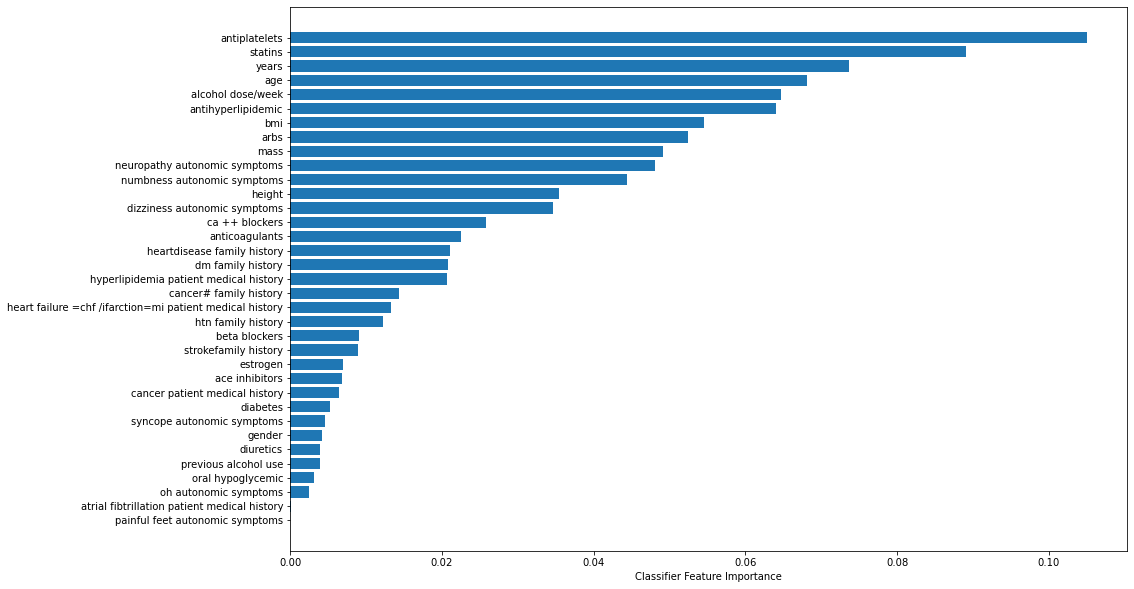

In [137]:
grid_search_res, y_test_pred_rf = search_best_model(X_train, y_train, X_test, y_test, classifier_rf, 3, parameter_grid)

Some features present only few patients within a category and therefore those feature are not informative here. The question is: would it be useful if we had more patients within those categories?
There are 112 patients in total let's compare the feature importance with the number of patients per category

In [138]:
sorted_idx = grid_search_res.best_estimator_.feature_importances_.argsort()
df_features_importance = pd.DataFrame({"columns" : X_stroke_encoded.columns[sorted_idx], 
                                       "importance" : grid_search_res.best_estimator_.feature_importances_[sorted_idx]})

In [139]:
df_features_importance.loc[0:10] #let's see for the first ten with the lowest importance

,columns,importance
0,painful feet autonomic symptoms,0.000000
1,atrial fibtrillation patient medical history,0.000071
2,oh autonomic symptoms,0.002518
3,oral hypoglycemic,0.003121
4,previous alcohol use,0.003936
5,diuretics,0.003942
6,gender,0.004144
7,syncope autonomic symptoms,0.004657
8,diabetes,0.005283
9,cancer patient medical history,0.006489


In [140]:
df_stroke_freq = df_stroke_v1.describe(include="all").loc["freq"].sort_values(ascending=False)
df_stroke_freq[0:10] #top 10 unbalnced categorical feature 

oral hypoglycemic                                           110
heart failure =chf /ifarction=mi patient medical history    109
estrogen                                                    109
diabetes                                                    109
atrial fibtrillation patient medical history                109
painful feet autonomic symptoms                             106
anticoagulants                                              104
arbs                                                        104
antihyperlipidemic                                          103
cancer patient medical history                               99
Name: freq, dtype: object

In [141]:
set(df_stroke_freq[0:10].index) & set(df_features_importance.loc[0:10, 'columns']) #common

{'atrial fibtrillation patient medical history',
 'cancer patient medical history',
 'diabetes',
 'oral hypoglycemic',
 'painful feet autonomic symptoms'}

In [142]:
features_diff_importance = set(df_features_importance.loc[0:10, 'columns']).difference(set(df_stroke_freq[0:10].index))
df_stroke_freq.loc[list(features_diff_importance)]

gender                        62
syncope autonomic symptoms    93
diuretics                     84
oh autonomic symptoms         79
ace inhibitors                83
previous alcohol use          83
Name: freq, dtype: object

We could still argue that if a feature has 80/90 patients with the same category this feature doesn't bring much information. However, this is very surprsising that gender is not part of the most important feature as described in the litterature...

Let's see the 10 most important features

In [143]:
df_features_importance.tail(10)

,columns,importance
25,neuropathy autonomic symptoms,0.048104
26,mass,0.049206
27,arbs,0.052398
28,bmi,0.054489
29,antihyperlipidemic,0.064062
30,alcohol dose/week,0.064750
31,age,0.068167
32,years,0.073619
33,statins,0.089130
34,antiplatelets,0.105045


In [144]:
df_features_importance.head(10)["columns"]

0                 painful feet autonomic symptoms
1    atrial fibtrillation patient medical history
2                           oh autonomic symptoms
3                               oral hypoglycemic
4                            previous alcohol use
5                                       diuretics
6                                          gender
7                      syncope autonomic symptoms
8                                        diabetes
9                  cancer patient medical history
Name: columns, dtype: object

Antiplatelets stop blood clot to form and and statins is a cholesterol-lowering drug. Those medications prevent stroke and are therefore a good indicator of your risk to have a stroke. What could be interesting here is that we smartcompanion could use wheter or not a patient is taking this medication instead of specifying the cholesterol level or other blood measures.

In this top 15, we found the 3 categories of feature: demographic, lifestyle (alcohol consumption), medical record (medication, symptoms).

Interestingly mass and height are all used here even though they are correlated to bmi.

For the further analysis let's try
- use this model on the perfusion dataset
- online clustering


In [145]:
X_perfusion_encoded = perfusion_encoded.drop("stroke patient medical history", axis="columns")
X_perfusion_encoded.dropna(inplace=True)

In [146]:
grid_search_res.best_estimator_.predict(X_perfusion_encoded)

array([0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 0, 2, 0])

# Dimensionality Reduction & Clustering

In [160]:
import prince
import umap
from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE

The objective is to 
- reduce the datasets dimensions to 2 or 3 using distance/similarity measures
- find clusters 

Because we have mixed data we can not apply traditional algorithms

## FAMD

In [148]:
X_stroke = df_stroke_v1.drop(labels="stroke patient medical history", axis="columns")
X_stroke_selected = X_stroke.drop(labels=df_features_importance["columns"].head(10), axis="columns")

In [149]:
famd = prince.FAMD(n_components=3, n_iter=3,
                   copy=True, check_input=True,
                   engine='sklearn',random_state=42)
famd = famd.fit(X_stroke_selected)
coords = famd.row_coordinates(X_stroke_selected)

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (13.98% inertia)', ylabel='Component 1 (9.82% inertia)'>

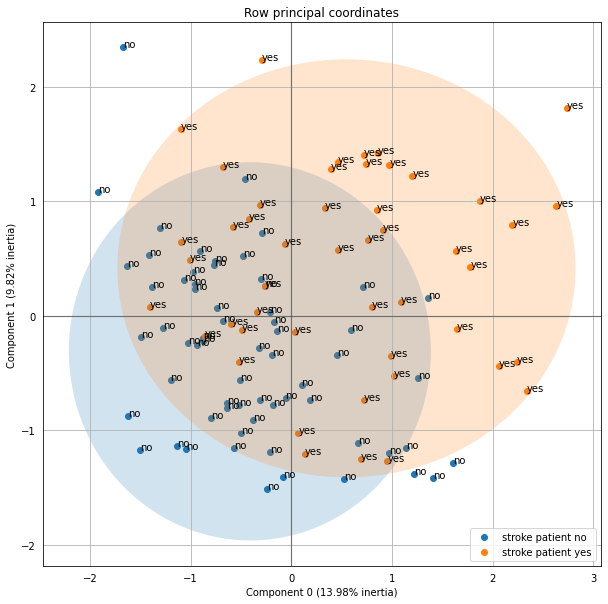

In [150]:
famd.plot_row_coordinates(
     X_stroke_selected,
     ax=None,
     figsize=(10, 10),
     x_component=0,
     y_component=1,
     labels=df_stroke_v1["stroke patient medical history"],
     color_labels=['stroke patient {}'.format(t) for t in df_stroke_v1["stroke patient medical history"]],
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True)

In [151]:
fig = px.scatter_3d(x=coords[0], y=coords[1], z=coords[2], size_max=15)
fig.update_traces(marker={'size': 3})
fig.show()

In [152]:
(famd.explained_inertia_).sum() #not enough

0.3262713158377971

## UMAP

In [153]:
def umap_embed(df, n_components=2, n_neighbors=10, intersection=False):

    numerical = df.select_dtypes(exclude='object').copy()

    for c in numerical.columns:
        numerical[c] = (numerical[c] - numerical[c].mean())/numerical[c].std(ddof=0)

    ##preprocessing categorical
    categorical = df.select_dtypes(include='object')
    categorical = pd.get_dummies(categorical).copy()

    #Embedding numerical & categorical
    fit1 = umap.UMAP(random_state=12,
                   n_components=n_components).fit(numerical)

    fit2 = umap.UMAP(metric='hamming',
                   n_neighbors=n_neighbors,
                   n_components=n_components).fit(categorical)


    # intersection will resemble the numerical embedding more.
    if intersection:
        embedding = fit1 * fit2

    # union will resemble the categorical embedding more.
    else:
        embedding = fit1 + fit2

    umap_embedding = embedding.embedding_
    return umap_embedding

In [154]:
umap_neighbord10 = umap_embed(X_stroke_selected, intersection=False)

/home/victoria/miniconda3/envs/ai4medicine/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable



In [155]:
px.scatter(umap_neighbord10[:, 0], umap_neighbord10[:, 1]).show()

## RandomForestEmbeding

In [156]:
grid_search_res.best_estimator_.fit(X_stroke_encoded, y_stroke_encoded)

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=42)

In [161]:
# computing 2D embedding with tsne, for visualization purposes
leaves = grid_search_res.best_estimator_.apply(X_stroke_encoded)
M = OneHotEncoder().fit_transform(leaves)

# we perform M*M.transpose(), which is the same to 
# computing all the pairwise co-ocurrences in the leaves 
S = (M*M.transpose()).todense()

# lastly, we normalize and subtract from 1, to get dissimilarities
D = 1 - S/S.max()
embed = TSNE(metric='precomputed', perplexity=30).fit_transform(D)

/home/victoria/miniconda3/envs/ai4medicine/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/victoria/miniconda3/envs/ai4medicine/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/victoria/miniconda3/envs/ai4medicine/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.

/home/victoria/miniconda3/envs/ai4medicine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning:

np.matrix usa

In [164]:
fig = px.imshow(S, text_auto=True)
fig.show()

In [165]:
fig = px.scatter(x=embed[:,0], y=embed[:,1], size_max=15, color=df_stroke_v1["stroke patient medical history"])
fig.update_traces(marker={'size': 3})
fig.show()

## Number of Cluster

In [171]:
# Function for plotting elbow curve
def plot_elbow_curve(start, end, data, categorical_index):
    no_of_clusters = list(range(start, end+1))
    cost_values = []
    
    for k in no_of_clusters:
        test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
        test_model.fit_predict(data, categorical=categorical_index)
        cost_values.append(test_model.cost_)
        
    sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    plt.plot();

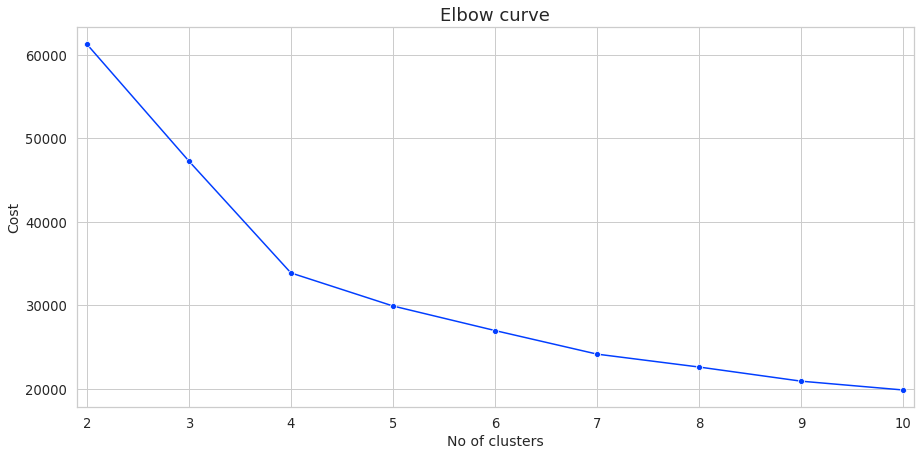

In [172]:
categorical_features = X_stroke_selected.dtypes[X_stroke_selected.dtypes == 'object'].index
categorical_features_idx = []

for col in categorical_features:
    categorical_features_idx.append(X_stroke_selected.columns.get_loc(col))
    
    
# Plotting elbow curve for k=2 to k=10
plot_elbow_curve(2,10, X_stroke_selected, categorical_features_idx )

## K-prototypes

In [173]:
model_4 = KPrototypes(n_clusters=4, init='Huang', random_state=42, n_jobs=-1)
model_4.fit_predict(X_stroke_selected, categorical=categorical_features_idx)
print(model_4.cost_)
#new column for cluster labels associated with each subject
model_4_results = X_stroke_selected.copy()
model_4_results['labels4'] = model_4.labels_

33866.84283627349


In [174]:
model_4_results.head()

,age,height,mass,bmi,years,alcohol dose/week,neuropathy autonomic symptoms,dizziness autonomic symptoms,numbness autonomic symptoms,cancer# family history,heartdisease family history,htn family history,dm family history,strokefamily history,heart failure =chf /ifarction=mi patient medical history,hyperlipidemia patient medical history,antiplatelets,anticoagulants,antihyperlipidemic,statins,estrogen,ace inhibitors,arbs,beta blockers,ca ++ blockers,labels4
patient id,,,,,,,,,,,,,,,,,,,,,,,,,,
s0011,70,1.6383,71.667594,26.701519,40.0,0.0,no,no,no,0.0,1.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,yes,no,no,0
s0033,65,1.8200,92.986000,28.072093,10.0,1.0,no,no,no,0.0,2.0,1.0,1.0,1.0,no,no,no,no,no,no,no,yes,no,no,no,1
s0044,74,1.7018,68.038855,23.493080,40.0,2.0,no,yes,yes,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,0
s0067,70,1.6764,68.492448,24.371788,0.0,7.0,no,no,no,1.0,0.0,0.0,0.0,1.0,no,no,no,no,no,no,no,no,no,no,no,3
s0068,79,1.5748,64.863709,26.154774,0.0,0.0,no,no,no,3.0,0.0,0.0,0.0,0.0,no,no,no,no,no,no,no,no,no,no,no,3


In [175]:
(model_4_results['labels4'] == 0).sum()

24

In [176]:
(model_4_results['labels4'] == 1).sum()

25

In [177]:
(model_4_results['labels4'] == 2).sum()

6

In [178]:
(model_4_results['labels4'] == 3).sum()

57